In [2]:
import sys
sys.path.append("..")

import numpy as np
from pprint import pprint
from collections import defaultdict
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, KeyedVectors
from functools import reduce

from src.seeds import Seeds
from src.dataset import Dataset
from src.gensim_word2vec_procrustes_align import smart_procrustes_align_gensim

### Training smaller models for each epoch

We consider 5 year intervals, but, when an interval is not well represented, it is merged to the previous one, until it reaches a meaningful quantity.

So the first step is to count the number of tokens for each epoch, to merge together those that lack.

In [3]:
interval = 1
# for each epoch, we load the dataset
epochs_len = defaultdict(lambda:0)
for year in [2000, 1980, 1960, 1940, 1920, 1900, 1860, 1840, 1820, 1800, 1760]:
    
    tokens = Dataset().load_dataset(year=year, fields={"tokens", "decision_date"})
    
    for t in tokens:
        d = t["decision_date"]
        date = d - d%interval 
        epochs_len[date] += len(t["tokens"])

If we plot the quantity of tokens for each interval we can see that some of them lack quite a bit, therefore, we merge lacking intervals together.

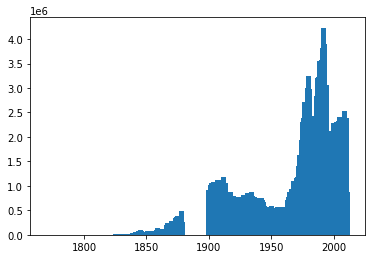

In [9]:
els = list(epochs_len.items())
els.sort()

plt.bar([e[0] for e in els], [e[1] for e in els], width=4)
plt.show()

The idea is to define a threshold and, while the current interval lacks, we merge with the previous.

The result shows that 2010 and 2005 mus tbe merged, 1970 and 1965, etc...
Also, we need to almost merge a century together to obtain 6mil tokens, from 1860 to 1770, this interval might be discarded later.

In [10]:
m = lambda x : ([x[0]], x[1])
els = list(map(m, els[::-1]))

res = []

threshold = 10**5
i = 0
while(i < len(els)):
    merged = False
    res.append(list(els[i]))
    while res[-1][1] < threshold and i < len(els)-1:
        merged = True
        res[-1][0] += els[i+1][0]
        res[-1][1] += els[i+1][1]
        i += 1
    i += 1       

res

[[[2011], 871680],
 [[2010], 2387739],
 [[2009], 2522980],
 [[2008], 2321166],
 [[2007], 2194725],
 [[2006], 2076677],
 [[2005], 2408830],
 [[2004], 2321677],
 [[2003], 2192961],
 [[2002], 2298801],
 [[2001], 2117724],
 [[2000], 2276048],
 [[1999], 1980256],
 [[1998], 2102454],
 [[1997], 1964297],
 [[1996], 2117028],
 [[1995], 2078554],
 [[1994], 3056249],
 [[1993], 3905105],
 [[1992], 4231734],
 [[1991], 3809063],
 [[1990], 3574970],
 [[1989], 3557835],
 [[1988], 3233647],
 [[1987], 3201587],
 [[1986], 2837281],
 [[1985], 2376927],
 [[1984], 2369097],
 [[1983], 2417526],
 [[1982], 2269689],
 [[1981], 2985391],
 [[1980], 3247989],
 [[1979], 2998890],
 [[1978], 2706148],
 [[1977], 2704664],
 [[1976], 2381736],
 [[1975], 2315140],
 [[1974], 1945847],
 [[1973], 1622054],
 [[1972], 1412870],
 [[1971], 1190658],
 [[1970], 1166674],
 [[1969], 1078392],
 [[1968], 1096276],
 [[1967], 944706],
 [[1966], 939688],
 [[1965], 882649],
 [[1964], 781827],
 [[1963], 711976],
 [[1962], 561705],
 [[1961

In [ ]:
def get_dataset_splits(intervals):
    m = lambda x : x - x%20
    return set(map(m, intervals))

### Training the models considering the gaps

In [ ]:
interval = 5
vector_size = 300
dataset = Dataset()

last_loaded = set()
for merged_intervals, splits in list(zip(res, [get_dataset_splits(e[0]) for e in res])):
    years = merged_intervals[0]

    print("Processing:", years)
    # if splits are already loaded don't do anything, 
    # otherwise load what you need
    if splits != last_loaded:
        last_loaded = splits
        tokens = []
        for split in splits:
            tokens += dataset.load_dataset(year=split, fields={"tokens", "decision_date"})

        epochs_tokens = defaultdict(lambda:[])
        for t in tokens:
            d = t["decision_date"]
            date = d - d%interval 
            epochs_tokens[date].append(t["tokens"])
    
    model_tokens = list(reduce(lambda a,b: a+b, [epochs_tokens[y] for y in years]))
    # check that tokens are in the right quantity
    assert(sum([len(e) for e in model_tokens]) == merged_intervals[1])
    # train and save
    model = Word2Vec(model_tokens, min_count=5, workers=4, vector_size = vector_size)
    model.save(f"../data/models/5_years_time_vectors/{'_'.join([str(y) for y in years])}_w2v.model")